In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [114]:
# 1. Encoding
def make_F(n):
    F0 = np.array([[1, 0], [1, 1]])
    F = F0
    while len(F) < n:
        F = np.kron(F0, F)
    return F

# Reverse shuffle: matrix that produces (odd indices, even indices) for a ROW VECTOR left multiplication
def make_Rn(n):
    Bn = np.zeros((n, n), dtype=int)
    for i in range(n//2):
        Bn[i, 2*i] = 1
        Bn[i+n//2, 2*i+1] = 1
    return Bn.T

def make_Bn(n):
    if n == 2:
        return np.eye(2, dtype=int)
    else:
        return make_Rn(n).dot(np.kron(np.eye(2, dtype=int), make_Bn(n//2)))

def make_Gn(n):
    Bn = make_Bn(n)
    F = make_F(n)
    return Bn.dot(F)

# message is u in Arikan paper
def encode(message):
    n = len(message)
    Gn = make_Gn(n)
    x = np.mod(message.dot(Gn), 2)
    return x

# 2. Decoding
# happens later

# 3. Actual code
# happens later

# Channel
def BSC(message, epsilon):
    errors = [1 if n < epsilon else 0 for n in np.random.random(len(message))]  # 1 means error occurs
    return np.mod(np.add(message, errors), 2)

def BEC(message, epsilon):
    errors = [np.NaN if n < epsilon else 0 for n in np.random.random(len(message))]  # 1 means error occurs
    return np.add(message, errors)

In [ ]:
# for n in [2, 4, 8]:
for n in [4, 8]:
    print("n =", n)
    print("F")
    print(make_F(n))
    print("Bn")
    print(make_Bn(n))
    print("Gn")
    print(make_Gn(n))

In [117]:
[1 if n < 0.8 else 0 for n in np.random.random(8)]
result = BEC([0, 0, 0, 1, 1, 1], 0.2)
print(result)
result[np.isnan(result)] = -1
print(result)

[ nan   0.   0.  nan   1.   1.]
[-1.  0.  0. -1.  1.  1.]


In [399]:
L1 = np.array([float("inf"), 0, 1])

def decode_BEC(y, u_frozen, frozen_idx, free_idx, epsilon):
    y, u_frozen, frozen_idx, free_idx = np.array(y), np.array(u_frozen), np.array(frozen_idx), np.array(free_idx)
    u_hat = np.zeros(len(y))
    u_hat[:] = np.NaN             # temporary
    u_hat[frozen_idx] = u_frozen
    
    y[np.isnan(y)] = -1
    y = np.array(y, dtype=int)
    
    N = len(y)
    L = np.zeros(N, dtype=int)
    frozen_idx_set = set(frozen_idx)
    for i in range(N):
#         print(i, N, y, u_hat)
        L[i] = compute_L(i, N, y, np.arange(N), u_hat)
        if i not in frozen_idx_set:
            u_hat[i] = L[i]
#         u_hat[i] = max(0, L[i])
#         print("L[", i, "] =", L[i])
#         print(L, u_hat)
    
    return u_hat

def compute_L(i, N, y, u_idx, u_hat):
    if N == 1:
        return y[0]
    
    global u
    inf = float("inf")
    
    if i % 2 == 0:
        uo = u_idx[ :i:2]
        ue = u_idx[1:i:2]
    else:
        uo = u_idx[ :i-1:2]
        ue = u_idx[1:i-1:2]
    
    a = compute_L(i//2, N//2, y[:N//2], np.mod(np.add(ue, uo), 2), u_hat)
    b = compute_L(i//2, N//2, y[N//2:], ue, u_hat)
    
    if i % 2 == 0:
#         retval = (a*b+1)/(a+b)
        if a != -1 and b != -1:
            return np.mod(a + b, 2)
        else:
            return -1
    else:
#         retval = a**(1-2*u[i-1])*b
        if b != -1:
            return b
        elif a != -1:
            return np.mod(a + u_hat[i-1], 2)
        else:
            return -1
    
#     N = len(y)
#     L = np.zeros(N)
#     for i in range(len(L)):
#         L[i] = make_L(y, N, u)

# L1 = np.array([float("inf"), 0, 1])
# # y is length-N array
# def make_L(y, N, u, i):
#     if N == 1:
#         return L1[y[0]]
#     else:
#         for i in range(N//1):
#             L[2*i] = make_L(y[:N//2], N//2)


def interleave(message, u_frozen, frozen_idx):
    full_message = np.zeros(len(message) + len(u_frozen))
    message_i = 0
    frozen_i = 0
    while message_i + frozen_i < len(full_message):
        i = message_i + frozen_i
        if frozen_i < len(u_frozen) and i == frozen_idx[frozen_i]:
            full_message[i] = u_frozen[frozen_i]
            frozen_i += 1
        else:
            full_message[i] = message[message_i]
            message_i += 1
    return full_message

In [400]:
u_guess = decode_BEC([np.NaN, 1, 0, 1, 0, 1, 0, 1], [0, 0, 0], [0, 1, 3], [2, 4, 5, 6, 7], 0.2)
print(u_guess)

[ 0.  0.  0.  0.  0.  0.  0.  1.]


In [401]:
epsilon = 0.1
u_frozen = np.array([0, 0, 0, 0])
frozen_idx = np.array([0, 1, 2, 4])
free_idx = np.array([3, 5, 6, 7])
message = np.array([1, 1, 1, 1])

# u_frozen = np.array([1, 0])
# frozen_idx = np.array([0, 3])
# message = np.array([1, 1])
# free_idx = np.array([1, 22])

full_message = interleave(message, u_frozen, frozen_idx)
print("start:", full_message)
x = encode(full_message)
print("x =", x)
y = BEC(x, epsilon)
print("y =", y)
message_hat = decode_BEC(y, u_frozen, frozen_idx, free_idx, epsilon)
print("end:", message_hat)

start: [ 0.  0.  0.  1.  0.  1.  1.  1.]
x = [ 0.  1.  1.  0.  1.  0.  0.  1.]
y = [ 0.  1.  1.  0.  1.  0.  0.  1.]
end: [ 0.  0.  0.  1.  0.  1.  1.  1.]


In [402]:
np.random.randint(0, 2, 10)

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0])

# frozen: 32
# free: 96
128
start: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  0.  1.  0.  1.  1.  0.  0.  0.  0.  1.  1.  0.  0.
  1.  1.  1.  0.  1.  0.  1.  0.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  1.  1.  0.  0.  0.  1.  1.  0.  0.  1.  1.  0.  1.
  1.  0.  0.  1.  1.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  1.  0.
  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.  0.  1.  1.  0.  1.  0.  1.  1.
  1.  0.]
x = [ 0.  1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.
  0.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  1.  1.
  1.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  0.  1.  0.  0.  0.
  0.  0.  1.  0.  1.  1.  1.  1.  1.  0.  0.  1.  0.  0.  1.  0.  1.  1.
  0.  1.  0.  0.  1.  1.  0.  1.  1.  0.  0.  1.  1.  1.  0.  1.  1.  1.
  

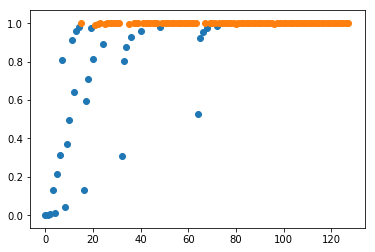

In [409]:
n = 128
epsilon = 0.1
threshold = 0.99

capacities = bec_capacity(n, epsilon)

frozen_idx = np.array([i for i in range(n) if capacities[i] < threshold])
u_frozen = np.zeros(len(frozen_idx))
free_idx = np.array([i for i in range(n) if capacities[i] >= threshold])
message = np.random.randint(0, 2, len(free_idx))

print("# frozen:", len(frozen_idx))
print("# free:", len(free_idx))
print(len(frozen_idx) + len(free_idx))

# u_frozen = np.array([1, 0])
# frozen_idx = np.array([0, 3])
# message = np.array([1, 1])
# free_idx = np.array([1, 22])

full_message = interleave(message, u_frozen, frozen_idx)
print("start:", full_message)
x = encode(full_message)
print("x =", x)
y = BEC(x, epsilon)
print("y =", y)
message_hat = decode_BEC(y, u_frozen, frozen_idx, free_idx, epsilon)
print("end:", message_hat)

if np.array_equal(full_message, message_hat):
    print("good shit")

print("min accuracy:", len(frozen_idx)/n)
print("accuracy:", np.sum(full_message == message_hat)/n)
    
plt.scatter(frozen_idx, capacities[frozen_idx])

plt.scatter(free_idx, capacities[free_idx])
plt.show()

In [5]:
# n: number of channels
# epsilon: BEC probability of erasure
def bec_capacity(n, epsilon):
    capacity = [1 - epsilon]
    while len(capacity) < n:
        capacity = [(I*I, I*(2-I)) for I in capacity]
        capacity = [item for sublist in capacity for item in sublist]
    return np.array(capacity)

# n: number of channels
def bsc_capacity(n, epsilon):
    capacity = [1 + epsilon*np.log(epsilon) + (1-epsilon)*np.log(1-epsilon) ]
    while len(capacity) < n:
        capacity = [(2*I*I, I*(2-2*I)) for I in capacity]
        capacity = [item for sublist in capacity for item in sublist]
    return np.array(capacity)

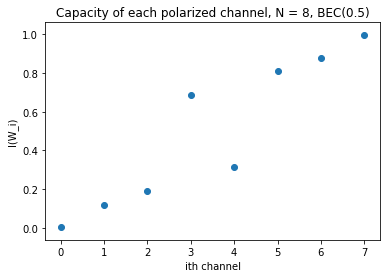

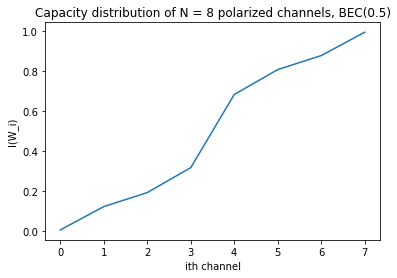

In [22]:
# capacity of BEC: 1 - probability of error
n = 8
capacities = bec_capacity(n, 0.5)

plt.title("Capacity of each polarized channel, N = 8, BEC(0.5)")
plt.xlabel("ith channel")
plt.ylabel("I(W_i)")
plt.scatter(np.arange(n), capacities)
plt.show()

plt.title("Capacity distribution of N = 8 polarized channels, BEC(0.5)")
plt.xlabel("ith channel")
plt.ylabel("I(W_i)")
plt.plot(np.arange(n), sorted(capacities))
plt.show()

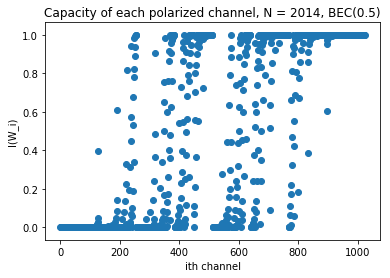

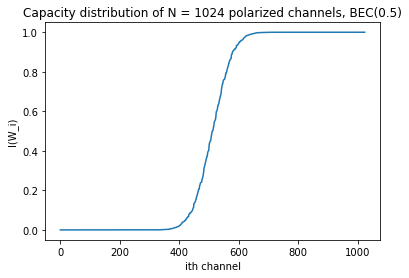

In [23]:
# capacity of BEC: 1 - probability of error
n = 1024
capacities = bec_capacity(n, 0.5)

plt.title("Capacity of each polarized channel, N = 2014, BEC(0.5)")
plt.xlabel("ith channel")
plt.ylabel("I(W_i)")
plt.scatter(np.arange(n), capacities)
plt.show()

plt.title("Capacity distribution of N = 1024 polarized channels, BEC(0.5)")

plt.xlabel("ith channel")
plt.ylabel("I(W_i)")
plt.plot(np.arange(n), sorted(capacities))
plt.show()

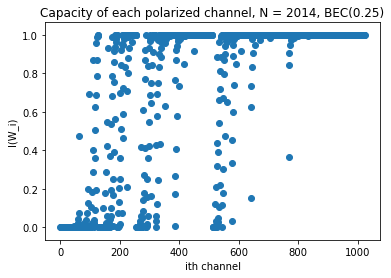

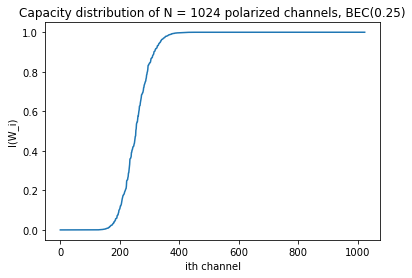

In [20]:
# capacity of BEC: 1 - probability of error
n = 1024
capacities = bec_capacity(n, 0.25)

plt.title("Capacity of each polarized channel, N = 2014, BEC(0.25)")
plt.xlabel("ith channel")
plt.ylabel("I(W_i)")
plt.scatter(np.arange(n), capacities)
plt.show()

plt.title("Capacity distribution of N = 1024 polarized channels, BEC(0.25)")

plt.xlabel("ith channel")
plt.ylabel("I(W_i)")
plt.plot(np.arange(n), sorted(capacities))
plt.show()

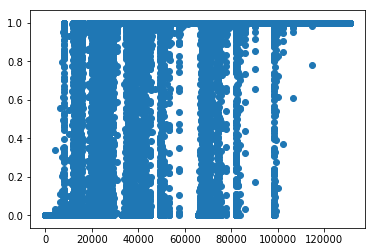

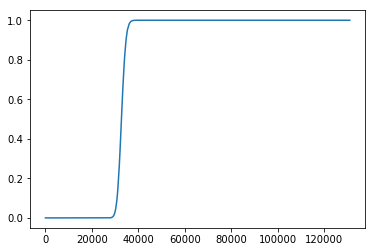

In [136]:
# capacity of BEC: 1 - probability of error
n = 128*1024
capacities = bec_capacity(n, 0.25)

plt.scatter(np.arange(n), capacities)
plt.show()

plt.plot(np.arange(n), sorted(capacities))
plt.show()

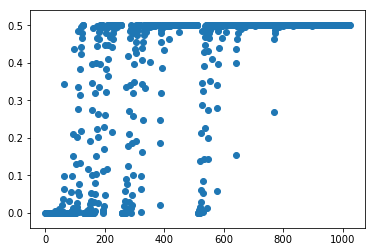

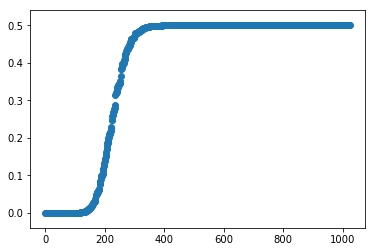

In [148]:
n = 1024
capacities = bsc_capacity(n, 0.3)

plt.scatter(np.arange(n), capacities)
plt.show()

plt.scatter(np.arange(n), sorted(capacities))
plt.show()

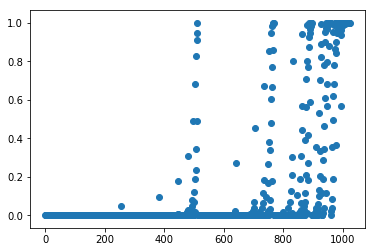

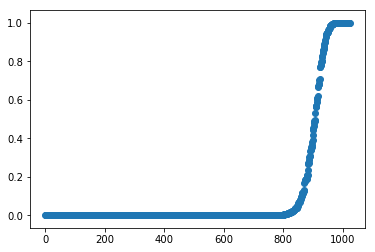

In [149]:
n = 1024
capacities = bec_capacity(n, 1-0.118709101)

plt.scatter(np.arange(n), capacities)
plt.show()

plt.scatter(np.arange(n), sorted(capacities))
plt.show()